<a href="https://colab.research.google.com/github/BabakBar/DeepVisions/blob/main/YOLOv8_ObjectDetection_PPE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Train YOLOv8 Object Detection on a PPE Dataset

---

## Note

Last run took place on **21.01.2023** with version **YOLOv8.0.20**.

## Tip: Use GPU Acceleration

If you are running this notebook in Google Colab, navigate to `Edit` -> `Notebook settings` -> `Hardware accelerator`, set it to `GPU`, and then click `Save`. This will ensure your notebook uses a GPU, which will significantly speed up model training times.

## Steps in this notebook

- Set Up Colan environment
- Install dependencies YOLOv8
- Roboflow Universe
- Preparing a custom dataset
- Custom Training
- Validate Model
- Inference with Model
- Export Model
- HuggingFace deployment

**Vamos!**

# Colab tips:

## Shortcuts and Tricks
 Ctrl + M H for help, Ctrl + M B to insert a code cell below, and Ctrl + Enter to run the current cell.

Code Snippets: Use the code snippets feature for common tasks. It's found in the sidebar and provides code for various common operations.

Version Control: Use the built-in version control to track changes or revert to previous versions if needed.

External Data Access: Easily import data from Google Drive with from google.colab import drive; drive.mount('/content/drive').

Efficient Data Loading: For faster data loading, consider hosting your data on Google Drive or using Google Cloud Storage.

Background Tasks: Run tasks in the background and get notified upon completion. For example, !nohup command & and then !tail -f nohup.out to check the output.

Useful Magic Commands: Utilize magic commands like %matplotlib inline for inline plots or %load_ext tensorboard for TensorBoard integration.

## Before start

Let's make sure that we have access to GPU. We can use `nvidia-smi` command to do that. In case of any problems navigate to `Edit` -> `Notebook settings` -> `Hardware accelerator`, set it to `GPU`, and then click `Save`.

In [1]:
!nvidia-smi

Mon Jan 22 02:03:57 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

Mounting Google Drive to the Colab virtual machine's file system.

In [2]:
from google.colab import drive
import os

# Mount Google Drive
drive.mount('/content/drive/')

# Set the path to the specific folder
RootDir = '/content/drive/My Drive/Colab_Notebooks/Yolo/PPE.v2i.yolov8'

# Change the current working directory to RootDir
os.chdir(RootDir)
print("Changed working directory to:", os.getcwd())


Mounted at /content/drive/
Changed working directory to: /content/drive/My Drive/Colab_Notebooks/Yolo/PPE.v2i.yolov8


Exploring dataset

In [3]:
import yaml
import os
from PIL import Image
import matplotlib.pyplot as plt

# Load the data.yaml file to check the dataset configuration
data_yaml_path = '/content/drive/My Drive/Colab_Notebooks/Yolo/PPE.v2i.yolov8/data.yaml'
with open(data_yaml_path, 'r') as yamlfile:
    data_yaml = yaml.load(yamlfile, Loader=yaml.FullLoader)
print(data_yaml)

# Check if the paths are correct
print("Training images path: ", data_yaml['train'])
print("Validation images path: ", data_yaml['val'])

{'path': '/content/drive/My Drive/Colab_Notebooks/Yolo/PPE.v2i.yolov8', 'train': '/content/drive/My Drive/Colab_Notebooks/Yolo/PPE.v2i.yolov8/train/images', 'val': '/content/drive/My Drive/Colab_Notebooks/Yolo/PPE.v2i.yolov8/valid/images', 'test': '/content/drive/My Drive/Colab_Notebooks/Yolo/PPE.v2i.yolov8/test/images', 'nc': 8, 'names': ['Boots', 'Ear-protection', 'Glass', 'Glove', 'Helmet', 'Mask', 'Person', 'Vest'], 'roboflow': {'workspace': 'siabar', 'project': 'ppe-plsuk', 'version': 2, 'license': 'CC BY 4.0', 'url': 'https://universe.roboflow.com/siabar/ppe-plsuk/dataset/2'}}
Training images path:  /content/drive/My Drive/Colab_Notebooks/Yolo/PPE.v2i.yolov8/train/images
Validation images path:  /content/drive/My Drive/Colab_Notebooks/Yolo/PPE.v2i.yolov8/valid/images


In [4]:
with open('/content/drive/My Drive/Colab_Notebooks/Yolo/PPE.v2i.yolov8/data.yaml', 'r') as stream:
    data_config = yaml.safe_load(stream)

print(data_config)


{'path': '/content/drive/My Drive/Colab_Notebooks/Yolo/PPE.v2i.yolov8', 'train': '/content/drive/My Drive/Colab_Notebooks/Yolo/PPE.v2i.yolov8/train/images', 'val': '/content/drive/My Drive/Colab_Notebooks/Yolo/PPE.v2i.yolov8/valid/images', 'test': '/content/drive/My Drive/Colab_Notebooks/Yolo/PPE.v2i.yolov8/test/images', 'nc': 8, 'names': ['Boots', 'Ear-protection', 'Glass', 'Glove', 'Helmet', 'Mask', 'Person', 'Vest'], 'roboflow': {'workspace': 'siabar', 'project': 'ppe-plsuk', 'version': 2, 'license': 'CC BY 4.0', 'url': 'https://universe.roboflow.com/siabar/ppe-plsuk/dataset/2'}}


In [5]:
train_images_path = os.path.join(os.path.dirname(data_yaml_path), data_yaml['train'])
train_images = os.listdir(train_images_path)
print(f"Number of training images: {len(train_images)}")  # Should show the number of training images


Number of training images: 318


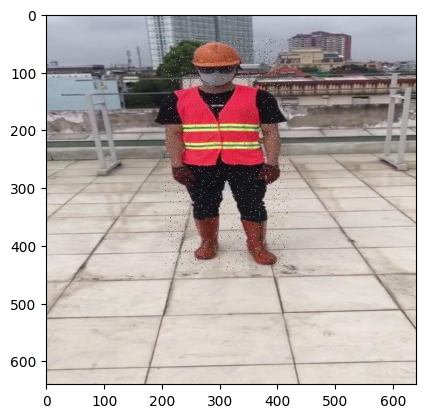

In [21]:
# Show a random image from the training set
train_images_path = os.path.join('/content/drive/MyDrive/Colab_Notebooks/Yolo/PPE.v2i.yolov8/', data_yaml['train'])
random_image_file = os.path.join(train_images_path, os.listdir(train_images_path)[165])
image = Image.open(random_image_file)
plt.imshow(image)
plt.show()

## Install YOLOv8

YOLOv8 can be installed in two ways - from the source and via pip. This is because it is the first iteration of YOLO to have an official package.

In [23]:
# Pip install method (recommended)

!pip install ultralytics

from IPython import display
display.clear_output()

import ultralytics
ultralytics.checks()

from ultralytics import YOLO
from IPython.display import display, Image

Ultralytics YOLOv8.1.4 🚀 Python-3.10.12 torch-2.1.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 26.3/78.2 GB disk)


In [24]:
!yolo task=detect mode=predict model=yolov8n.pt conf=0.25 source='/content/drive/MyDrive/Colab_Notebooks/Yolo/Sample_Images/TestCar0.jpg' save=True

100% 6.23M/6.23M [00:00<00:00, 164MB/s]
Ultralytics YOLOv8.1.4 🚀 Python-3.10.12 torch-2.1.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLOv8n summary (fused): 168 layers, 3151904 parameters, 0 gradients, 8.7 GFLOPs

image 1/1 /content/drive/MyDrive/Colab_Notebooks/Yolo/Sample_Images/TestCar0.jpg: 448x640 7 persons, 3 cars, 73.4ms
Speed: 13.5ms preprocess, 73.4ms inference, 769.9ms postprocess per image at shape (1, 3, 448, 640)
Results saved to runs/detect/predict
💡 Learn more at https://docs.ultralytics.com/modes/predict


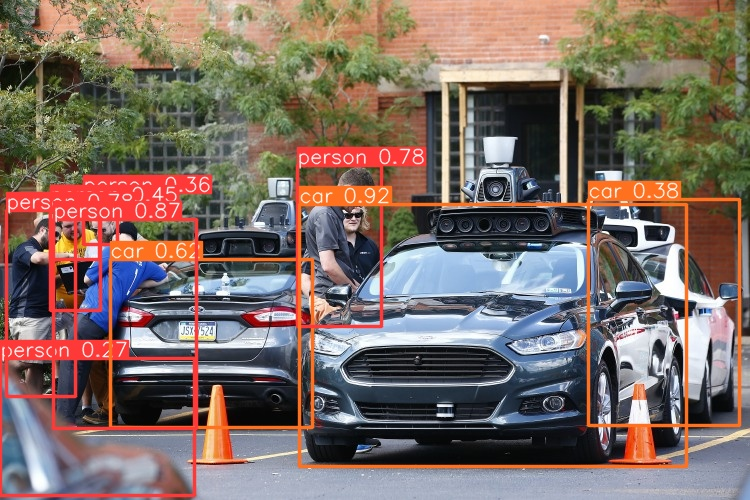

In [26]:
import glob

# Get the most recent directory name in runs/detect
list_of_dirs = glob.glob('runs/detect/*')
latest_dir = max(list_of_dirs, key=os.path.getmtime)

# List all image files in the latest directory
image_files = glob.glob(f"{latest_dir}/*")

# Display the images in the notebook
for image_path in image_files:
    display(Image(filename=image_path))

In [ ]:
%cd {RootDir}
Image(filename='/content/runs/detect/predict2/TestCar0.jpg', height=600)

In [ ]:
%cd {RootDir}
!yolo task=detect mode=predict model=yolov8n.pt conf=0.25 source='/content/TestPPE0.png' save=True

/content
Ultralytics YOLOv8.0.225 🚀 Python-3.10.12 torch-2.1.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLOv8n summary (fused): 168 layers, 3151904 parameters, 0 gradients, 8.7 GFLOPs

WARNING ⚠️ NMS time limit 0.550s exceeded
image 1/1 /content/TestPPE0.png: 640x640 16 persons, 4 dogs, 1 handbag, 1 sports ball, 1 chair, 9.8ms
Speed: 5.7ms preprocess, 9.8ms inference, 664.3ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs/detect/predict3
💡 Learn more at https://docs.ultralytics.com/modes/predict


/content


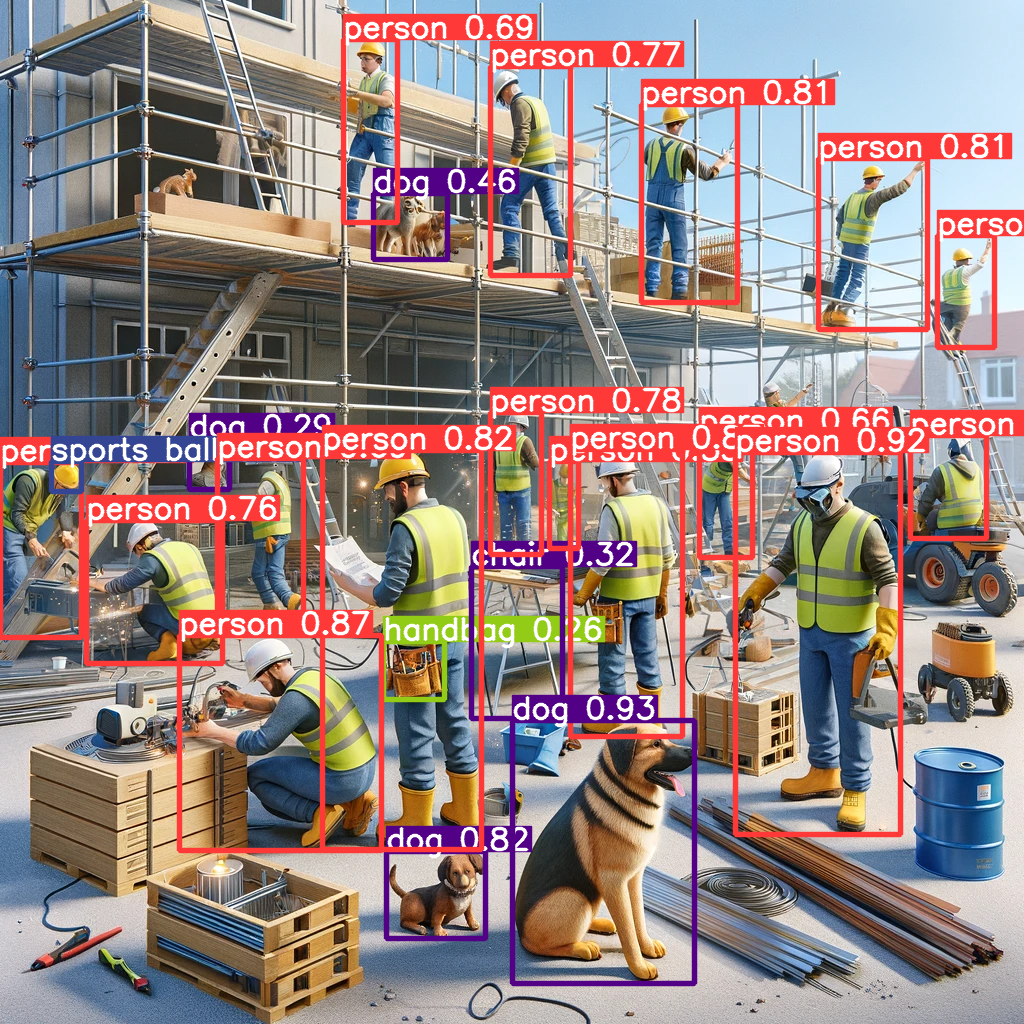

In [ ]:
%cd {RootDir}
Image(filename='/content/runs/detect/predict3/TestPPE0.png', height=600)

## Custom Training

In [ ]:
#!pip install -U torch torchvision torchaudio

In [27]:
%cd /content/drive/MyDrive/Colab_Notebooks/Yolo/PPE.v2i.yolov8

!yolo task=detect mode=train model=yolov8n.pt data=data.yaml epochs=100 imgsz=640 plots=True

/content
Ultralytics YOLOv8.1.4 🚀 Python-3.10.12 torch-2.1.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=data.yaml, epochs=100, time=None, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=Tru

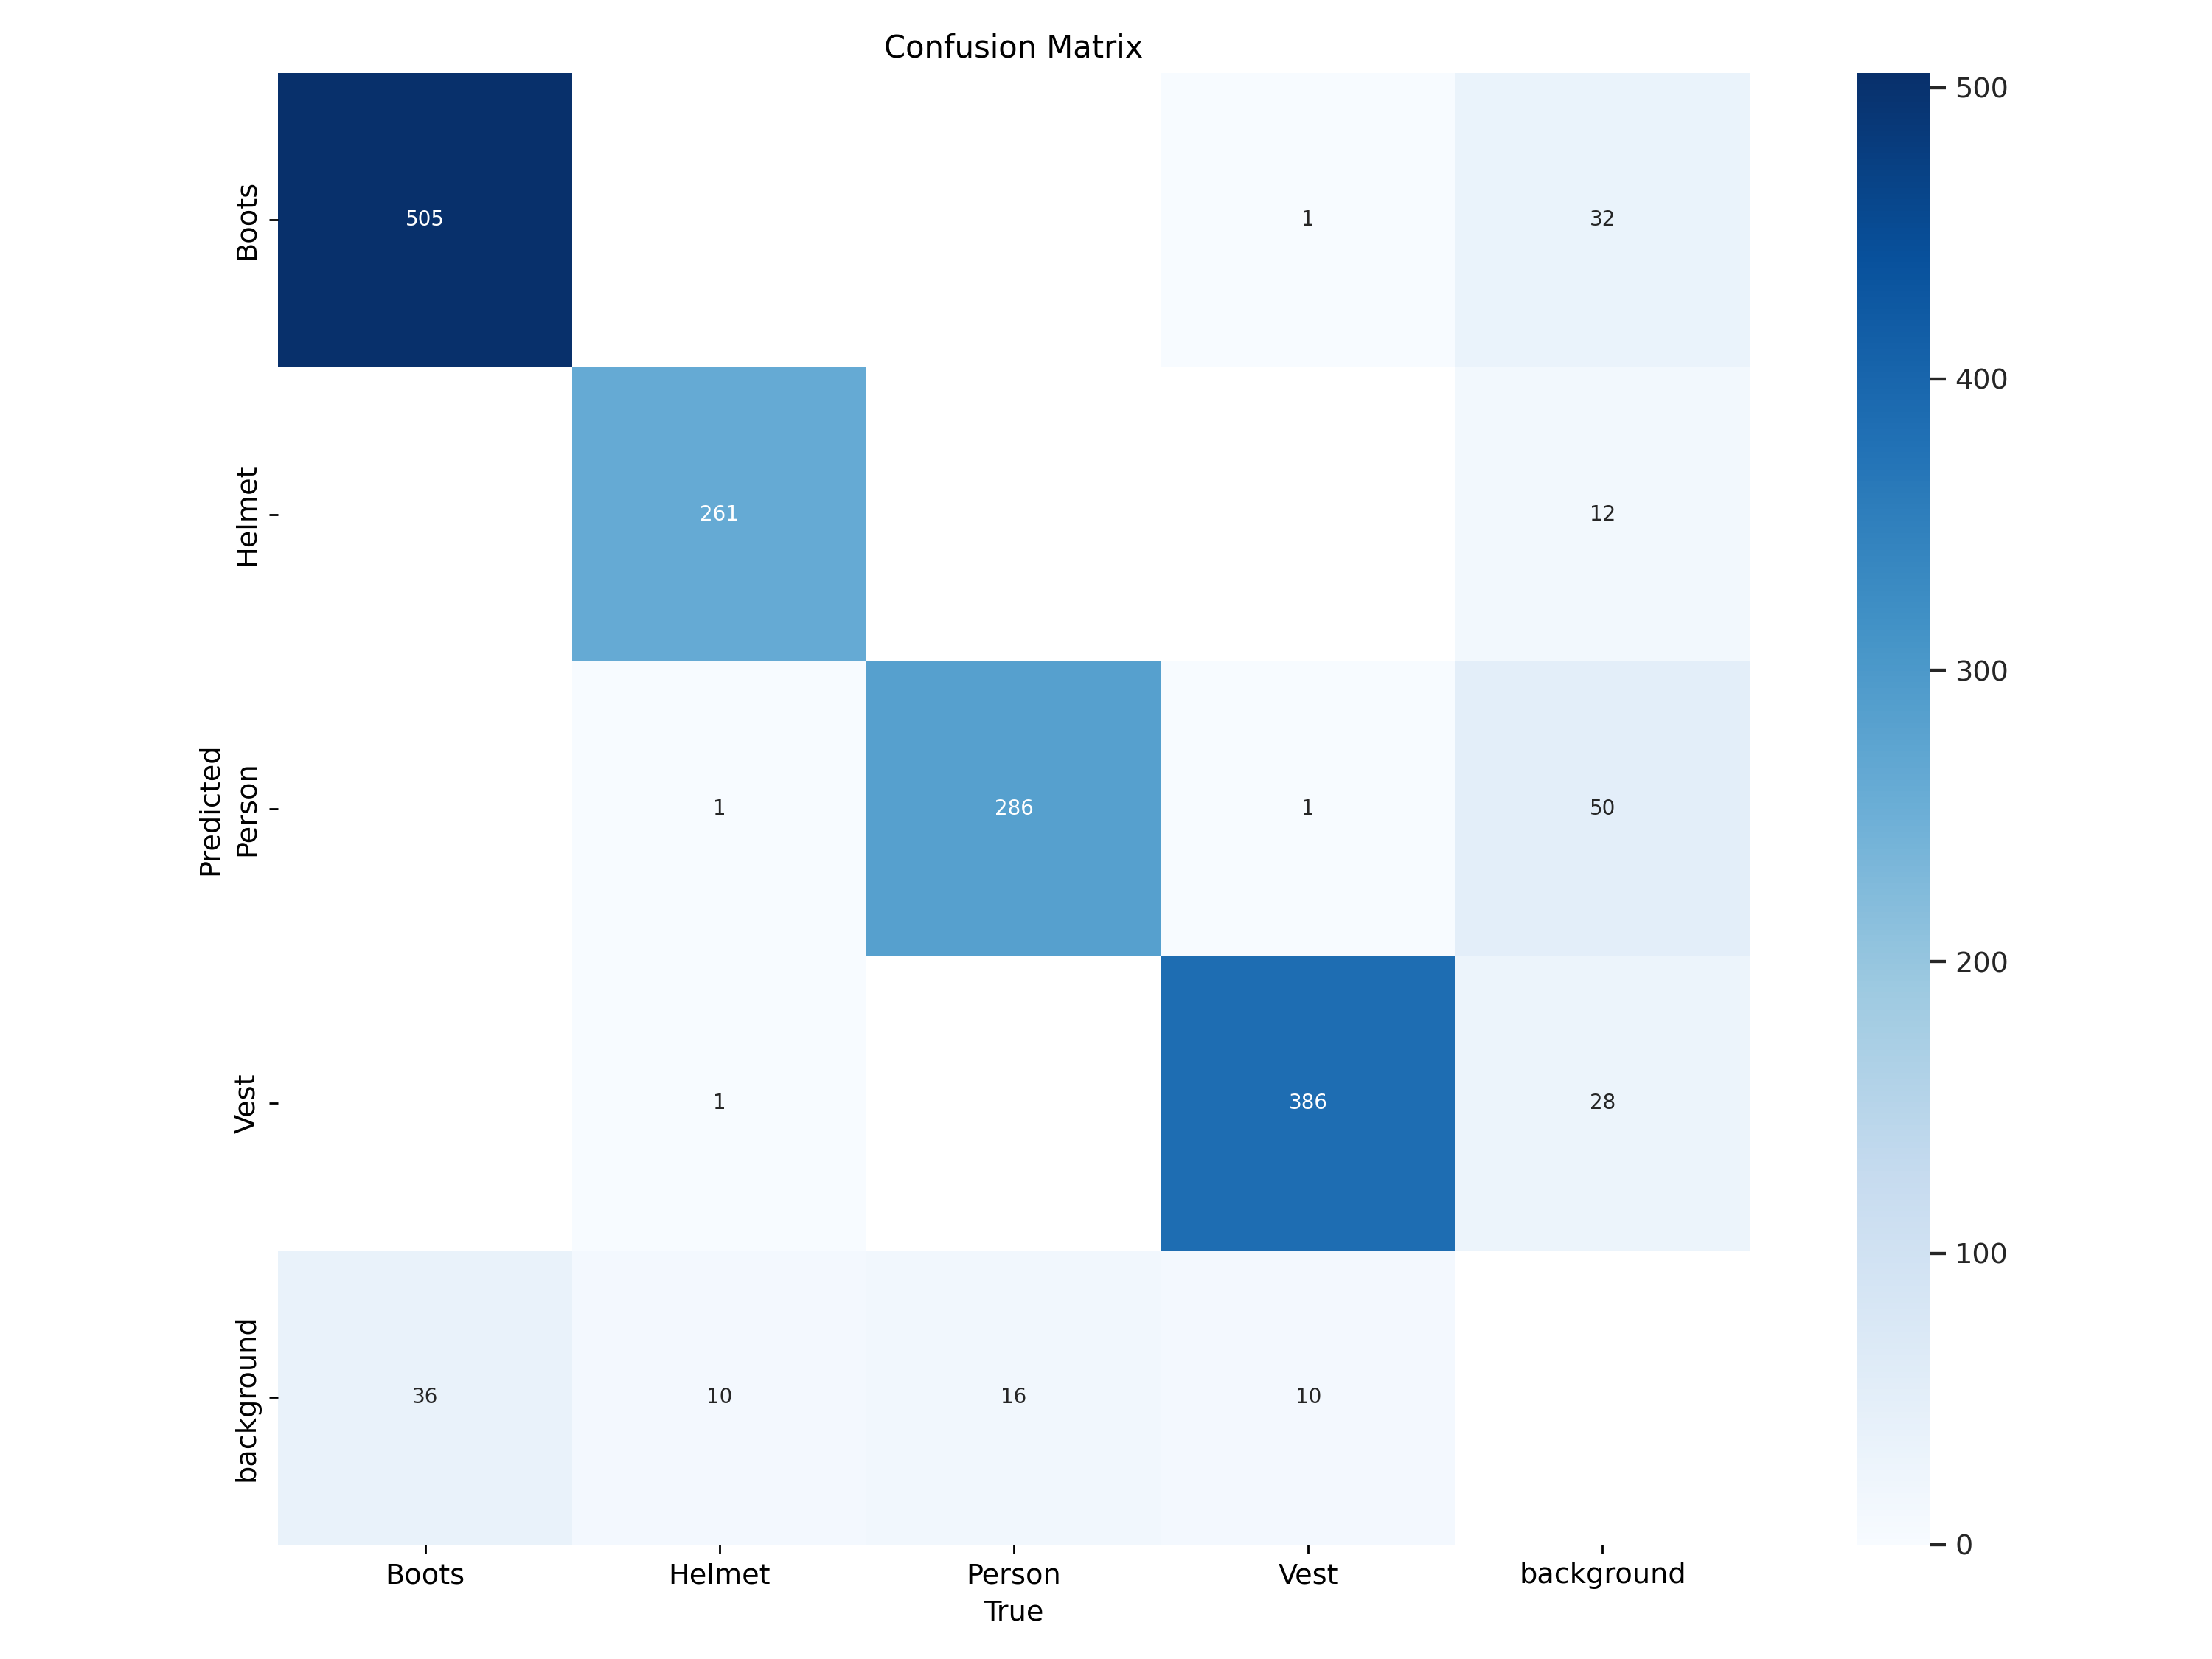

In [ ]:
from IPython.display import Image, display

# Define the path to the confusion matrix
confusion_matrix_path = '/content/datasets/PPE-1/runs/detect/train/confusion_matrix.png'

# Display the confusion matrix
display(Image(filename=confusion_matrix_path, width=600))


Here’s how to interpret the confusion matrix:

Diagonal Cells (True Positives): The cells on the diagonal of the matrix represent correct predictions. The values indicate the proportion of true positives for each class, i.e., the percentage of times the model correctly predicted each class. For example, 'Boots' were correctly predicted 93% of the time, 'Helmet' 96%, 'Person' 95%, and 'Vest' 97%.

Off-Diagonal Cells (False Positives and False Negatives): The off-diagonal cells represent incorrect predictions. For instance, the 'Boots' class has 0.07 in the 'background' row, indicating that 7% of the time, 'Boots' were incorrectly predicted as 'background'.

Background Class: The 'background' class indicates the absence of objects or any other class not of interest. Your matrix shows that the model occasionally misclassifies objects as 'background' (e.g., 'Person' is misclassified as 'background' 5% of the time).

Row Sum: Each row in the matrix sums up to 1.0, which would be 100% if you were looking at a non-normalized matrix. For example, the 'Person' row shows that 95% of the 'Person' predictions were correct, while 5% were incorrectly predicted as 'background'.

Column for Background Predictions: The last column shows the proportion of times each class was incorrectly predicted as 'background'. This is particularly important in scenarios where detecting the object is crucial and misclassifications as 'background' could be costly

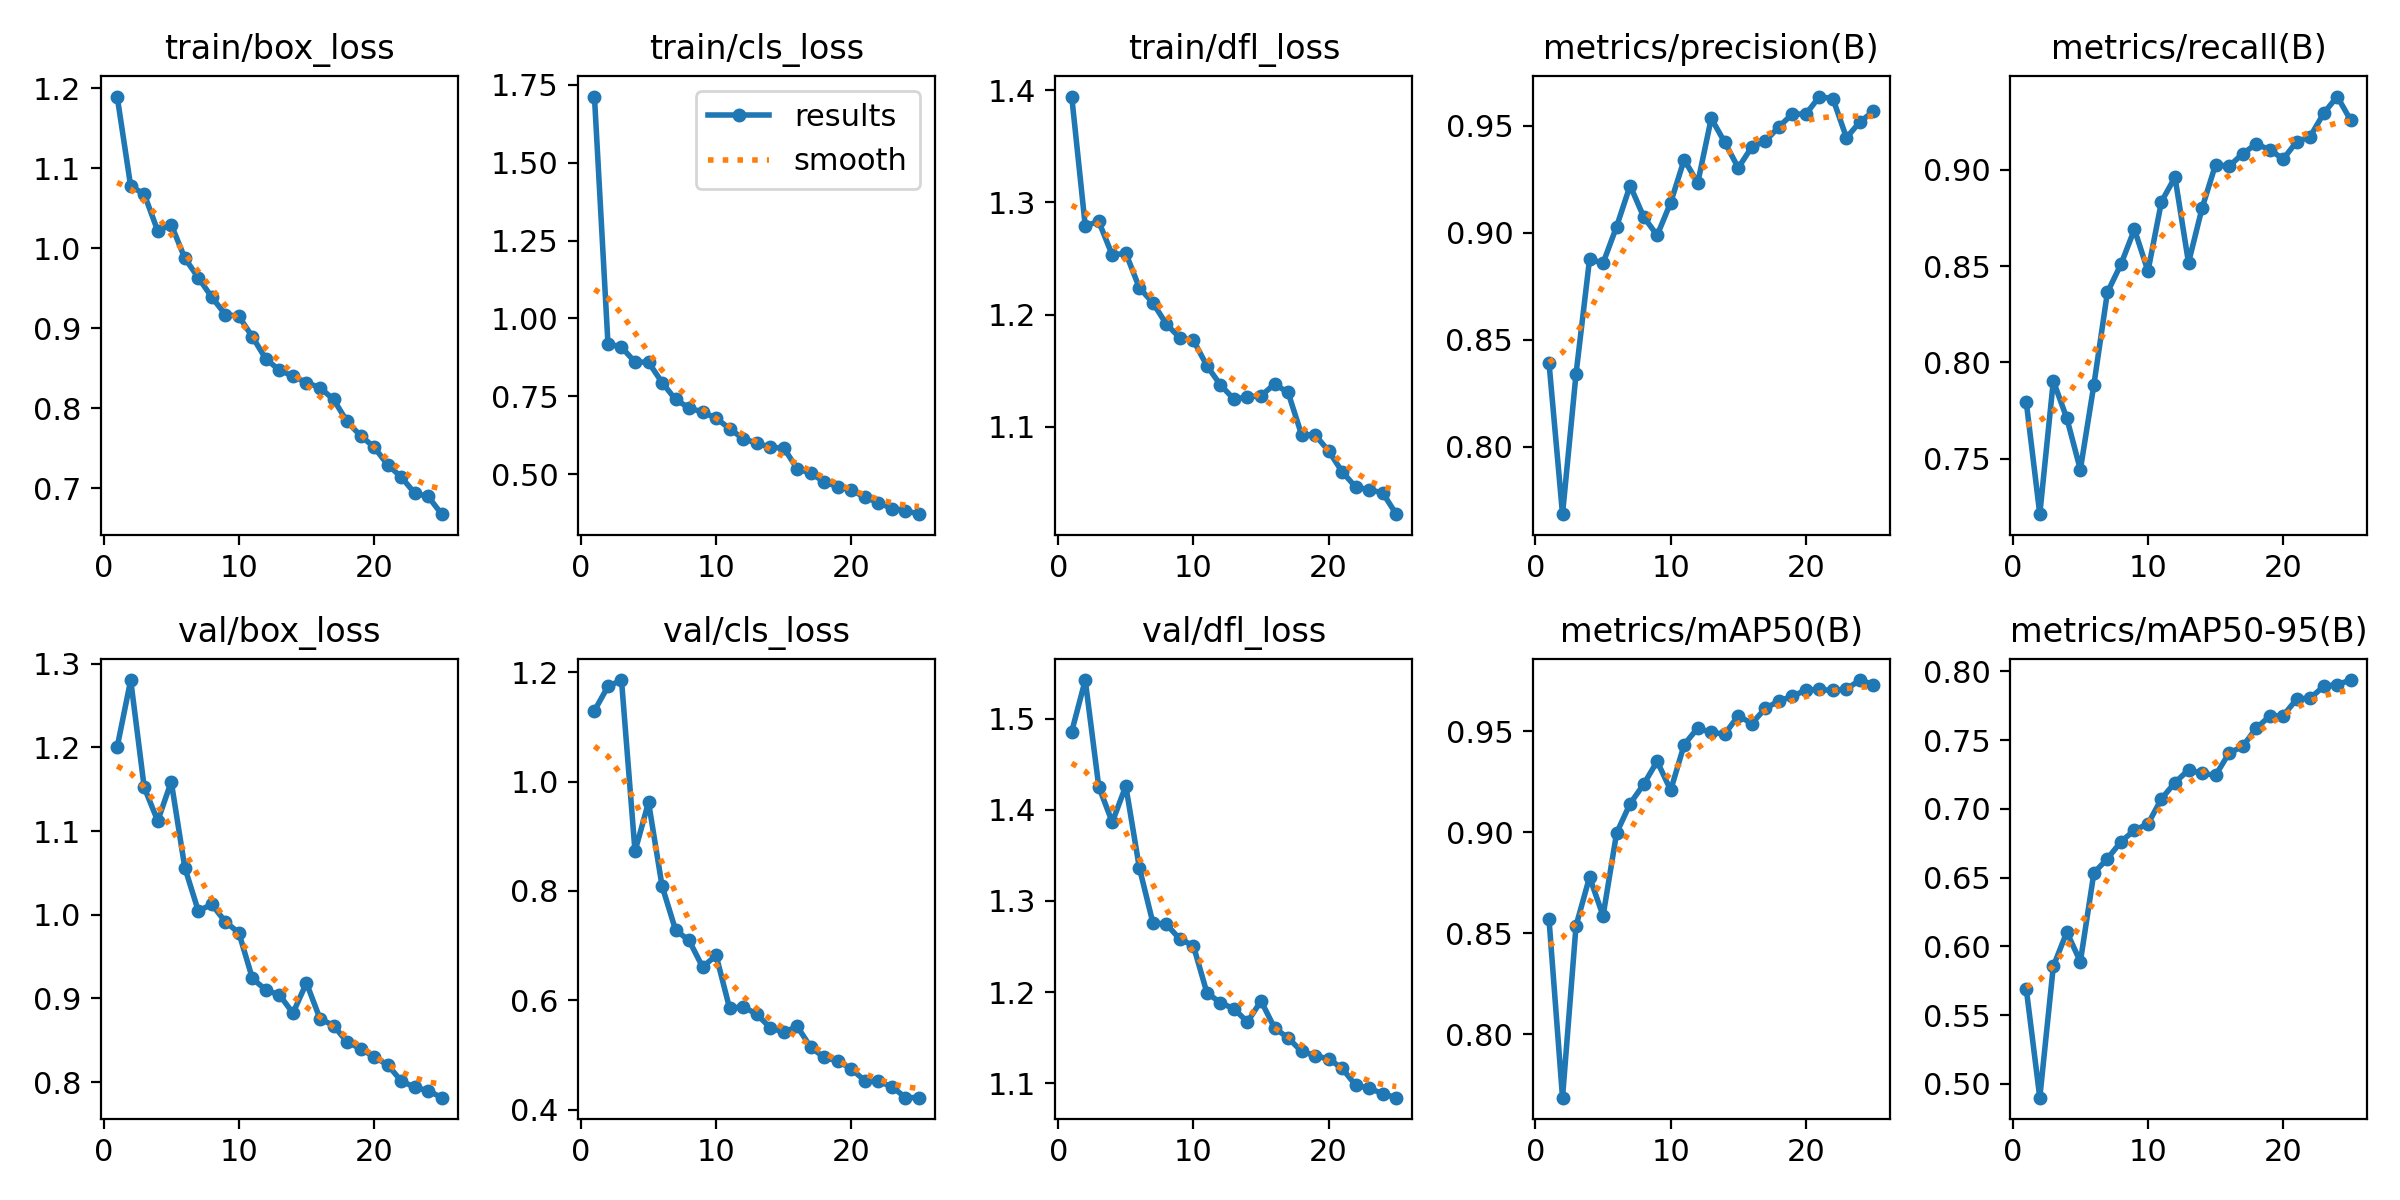

In [ ]:
Image(filename=f'/content/datasets/PPE-1/runs/detect/train/results.png', width=600)

A breakdown of each plot:

Train/Box Loss and Val/Box Loss: These plots show the loss associated with the bounding box predictions during training and validation. The downward trend indicates that the model is getting better at predicting the correct location of objects over time.

Train/Cls Loss and Val/Cls Loss: These show the classification loss during training and validation. The model is learning to correctly classify the objects in the bounding boxes, with the loss decreasing over epochs, which is a good sign.

Train/Dfl Loss and Val/Dfl Loss: Dfl loss refers to the directional field loss, which is a measure of how well the model predicts the 'direction' or 'orientation' of the objects. The decline in this loss means the model's predictions are aligning better with the true directions of the objects over time.

Metrics/Precision (B): Precision measures the accuracy of the positive predictions. The metric is improving, indicating a lower false positive rate as training progresses.

Metrics/Recall (B): Recall measures the model's ability to find all the actual positives. The increase in recall suggests that the model is identifying more of the true positives over time.

Metrics/mAP50 (B): Mean Average Precision at an Intersection over Union (IoU) threshold of 0.5. This metric considers both precision and recall at a specific IoU threshold. An upward trend is desirable, showing that overall detection performance is improving.

Metrics/mAP50-95 (B): This is the mean Average Precision calculated by averaging mAP at different IoU thresholds, from 0.5 to 0.95 (in steps of 0.05). This is a more stringent metric because it requires the model to be accurate at various strictness levels of IoU. The increase here suggests the model is becoming robust at detecting objects across different IoU thresholds.

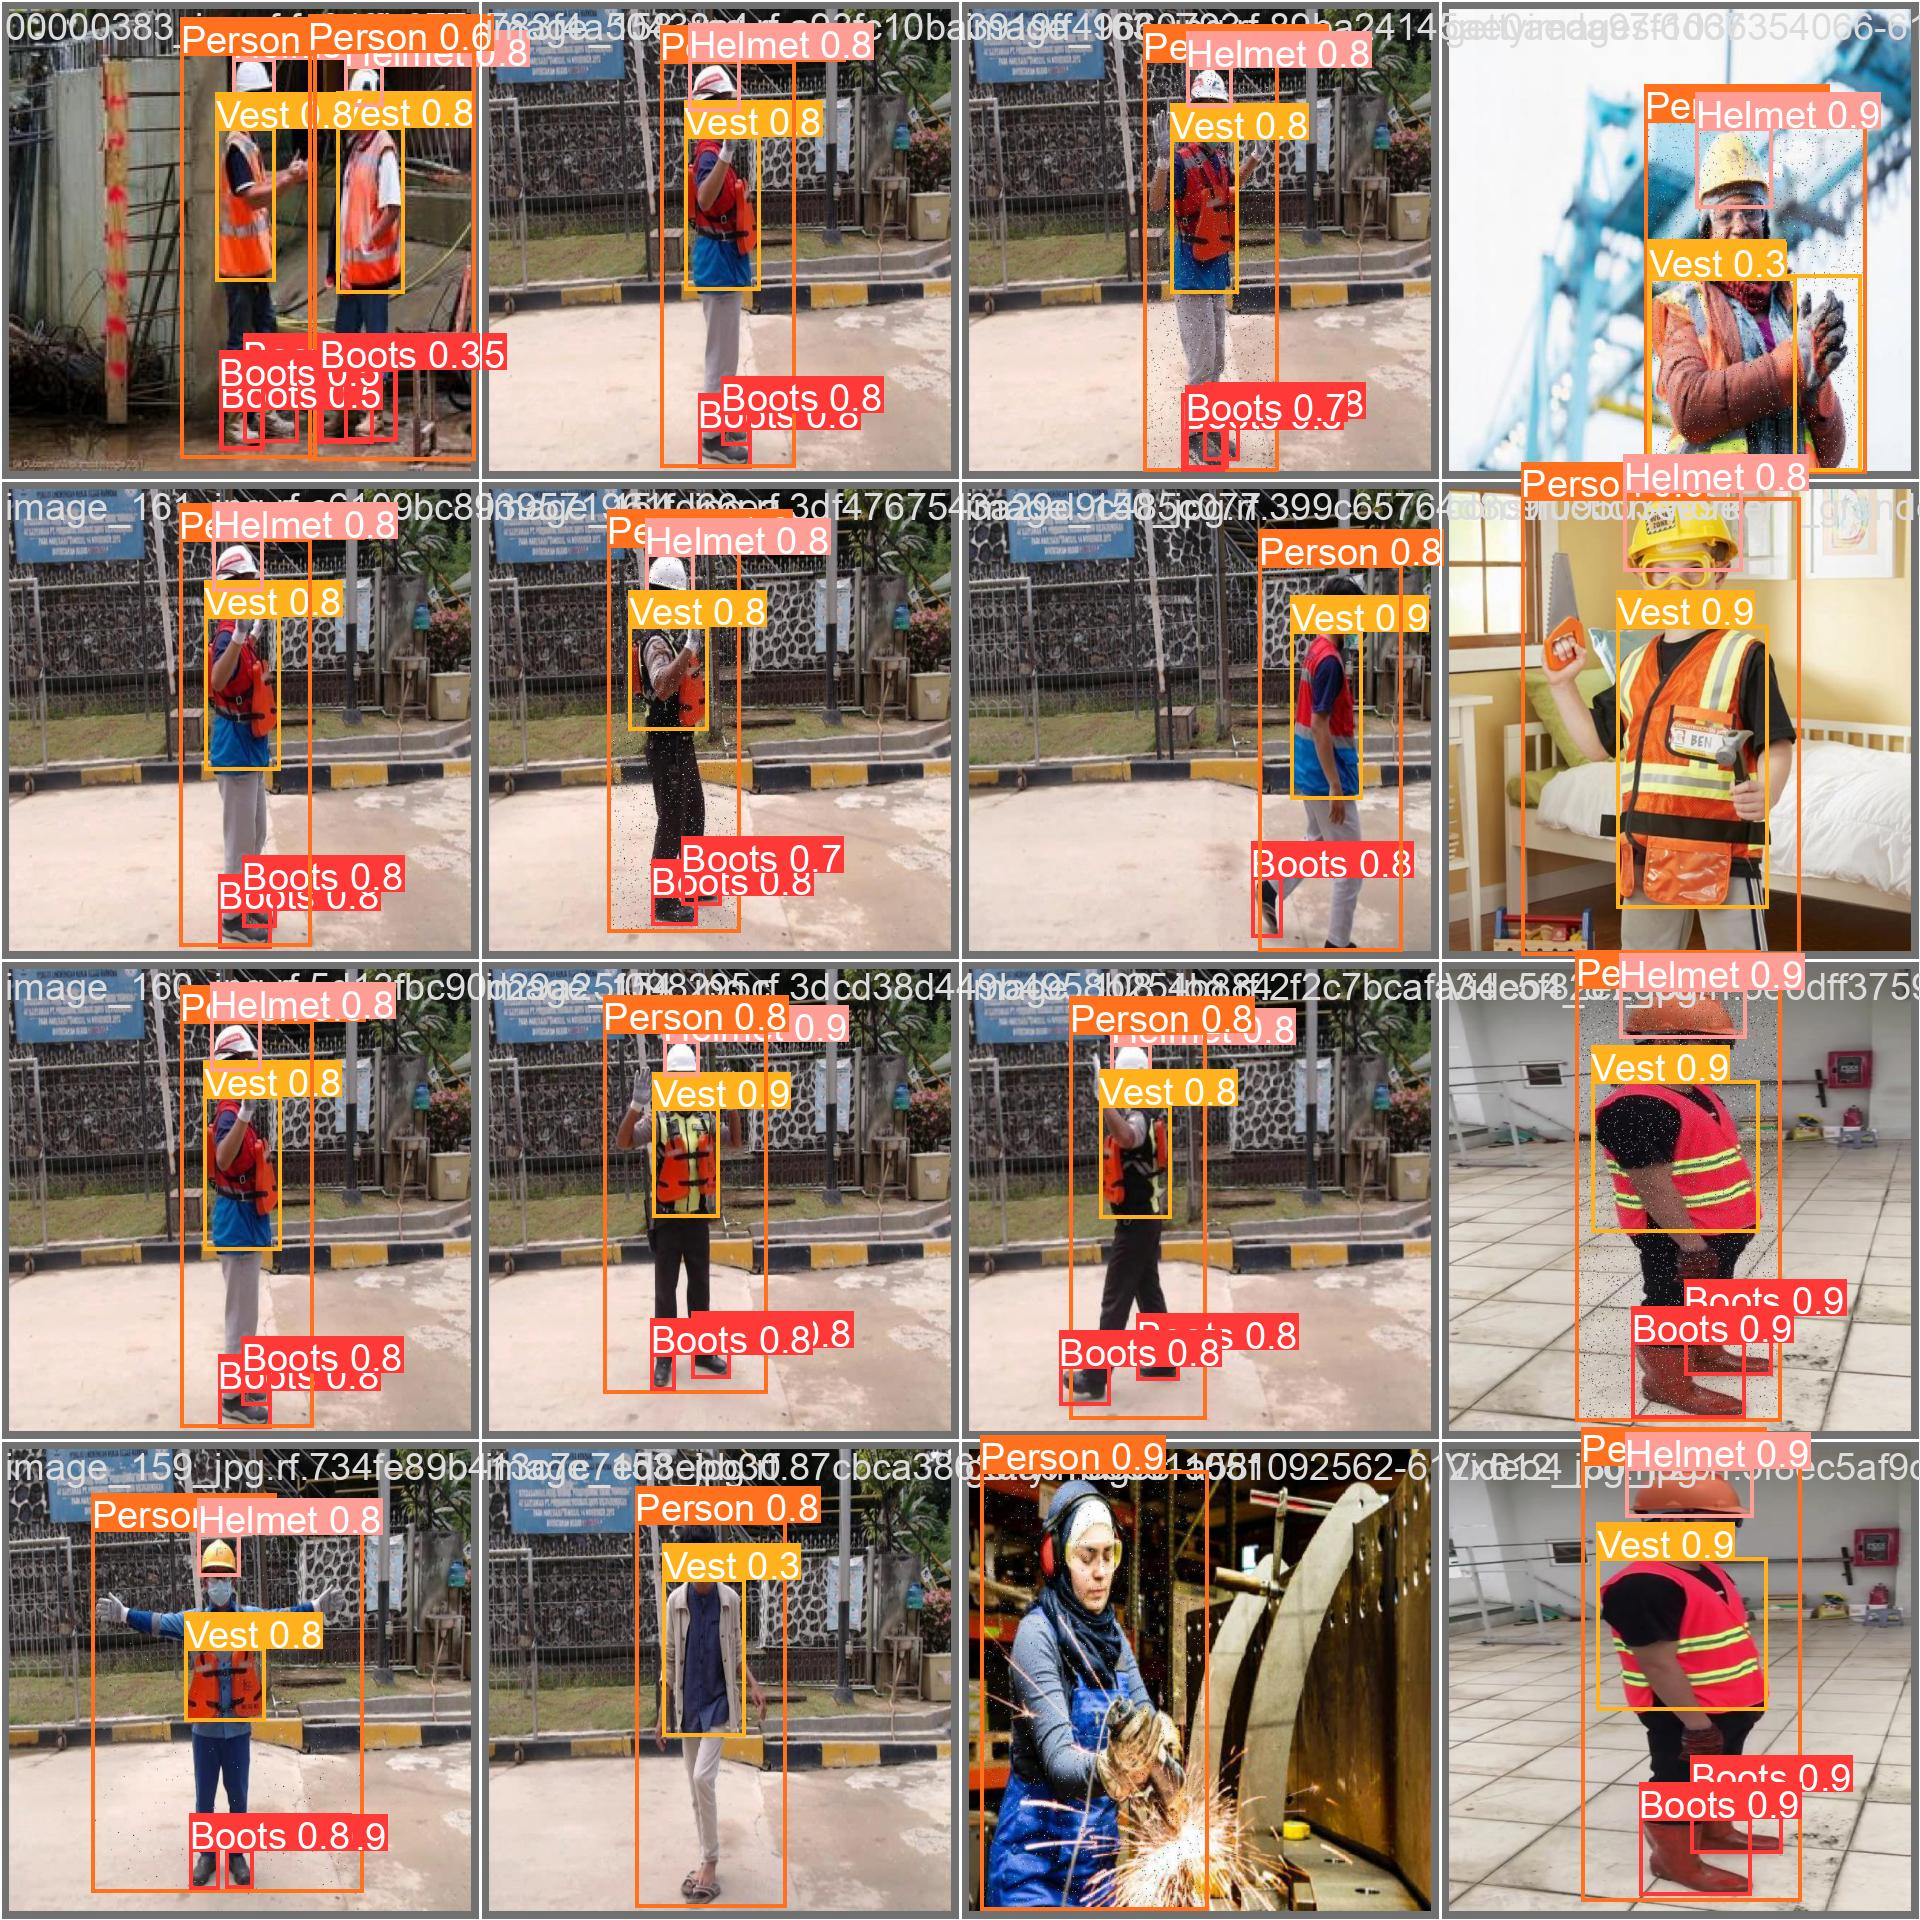

In [ ]:
Image(filename=f'/content/datasets/PPE-1/runs/detect/train/val_batch0_pred.jpg', width=600)

## Validate Custom Model

In [28]:
%cd /content/drive/MyDrive/Colab_Notebooks/Yolo/PPE.v2i.yolov8

# Set the path to your dataset and model weights
dataset_location = '/content/drive/MyDrive/Colab_Notebooks/Yolo/PPE.v2i.yolov8'
model_weights = '/content/drive/MyDrive/Colab_Notebooks/Yolo/PPE.v2i.yolov8/runs/detect/train/weights/best.pt'

# Run the validation command
!yolo task=detect mode=val model={model_weights} data={dataset_location}/data.yaml imgsz=640


/content
Ultralytics YOLOv8.1.4 🚀 Python-3.10.12 torch-2.1.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 3007208 parameters, 0 gradients, 8.1 GFLOPs
val: Scanning /content/drive/My Drive/Colab_Notebooks/Yolo/PPE.v2i.yolov8/valid/labels.cache... 57 images, 0 backgrounds, 0 corrupt: 100% 57/57 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% 4/4 [00:08<00:00,  2.06s/it]
                   all         57        290      0.902      0.816      0.908      0.625
                 Boots         57        103      0.941       0.67      0.873      0.472
                Helmet         57         43      0.854      0.884       0.92      0.643
                Person         57         64      0.927      0.797      0.892       0.69
                  Vest         57         80      0.887      0.912      0.949      0.696
Speed: 21.8ms preprocess, 26.3ms inference, 0.0ms loss, 26.2ms postprocess per image
Results sav

Model Summary: Shows that your model has 168 layers, over 11 million parameters, and a computational complexity of 28.4 GFLOPs. This summary is useful for understanding the size and capacity of your model.

Validation Dataset Scan: It indicates that the validation dataset consists of 326 images with a total of 1514 instances (objects) labeled across them. No backgrounds or corrupt images were found, ensuring that all images were suitable for validation.

Performance Metrics:

Box(P): The precision for bounding box predictions. It measures the correctness of the object detections (i.e., how many detections were actual objects). A score of 0.957 means that 95.7% of the detections were correct.
R (Recall): The recall score measures the model's ability to find all the actual objects. A score of 0.926 indicates that the model identified 92.6% of all objects.
mAP50: Mean Average Precision at an Intersection over Union (IoU) threshold of 0.5. It combines precision and recall into a single metric for detection accuracy. A high score of 0.973 suggests excellent model performance at this IoU threshold.
mAP50-95: This is the mean Average Precision calculated across a range of IoU thresholds from 0.5 to 0.95. Your score of 0.794 is quite robust, indicating good model predictions across different IoU levels.
Class-Specific Performance: The model's performance is also broken down by class:

Boots: High precision (0.98) and mAP50 (0.97), but slightly lower recall (0.897), indicating that while most boots detections are correct, some are missed.
Helmet: Balanced precision (0.963) and recall (0.945) with a high mAP50 (0.973).
Person: Lower precision (0.912) relative to other classes, but still high recall (0.907) and mAP50 (0.962).
Vest: Very high precision (0.973) and the highest mAP50 (0.988) among the classes, with a strong recall (0.952) as well.
Speed Metrics: The model processes each image in a matter of milliseconds, which is broken down into preprocessing, inference, and postprocessing times. This indicates a good speed performance for real-time applications.

Results Location: The results of the validation, including any output files (e.g., images with drawn predictions, detailed metrics), are saved in runs/detect/val.

## Inference with Custom Model

The confidence threshold will filter out any detections that the model is not at least 25% confident about. A lower threshold may result in more detections but can also increase the number of false positives.

In [32]:
# Correct model weights path
model_weights = '/content/drive/MyDrive/Colab_Notebooks/Yolo/PPE.v2i.yolov8/runs/detect/train/weights/best.pt'

# Image or directory of images for inference
source = '/content/drive/MyDrive/Colab_Notebooks/Yolo/PPE.v2i.yolov8/test/images'

# Run the inference
!yolo task=detect mode=predict model={model_weights} conf=0.25 source={source} save=True


Ultralytics YOLOv8.1.4 🚀 Python-3.10.12 torch-2.1.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 3007208 parameters, 0 gradients, 8.1 GFLOPs

image 1/57 /content/drive/MyDrive/Colab_Notebooks/Yolo/PPE.v2i.yolov8/test/images/00027_jpg.rf.761d147a0fd78a96a2a9c433f6c3d94c.jpg: 640x640 2 Vests, 8.3ms
image 2/57 /content/drive/MyDrive/Colab_Notebooks/Yolo/PPE.v2i.yolov8/test/images/00037_jpg.rf.bb5a6d427fca94c4ccf448f5877dac83.jpg: 640x640 1 Vest, 7.5ms
image 3/57 /content/drive/MyDrive/Colab_Notebooks/Yolo/PPE.v2i.yolov8/test/images/00048_jpg.rf.d1f7712f99e78643d2517e5c779614b4.jpg: 640x640 1 Helmet, 2 Vests, 7.4ms
image 4/57 /content/drive/MyDrive/Colab_Notebooks/Yolo/PPE.v2i.yolov8/test/images/00103_jpg.rf.59724edbd9ed4cb0bd346a8f2f320c36.jpg: 640x640 1 Helmet, 2 Persons, 2 Vests, 7.8ms
image 5/57 /content/drive/MyDrive/Colab_Notebooks/Yolo/PPE.v2i.yolov8/test/images/00126_jpg.rf.9720e28cc2dafda58394c11615feb774.jpg: 640x640 1 Vest, 7.4ms
image 6/57 /content/drive

**NOTE:** Let's take a look at few results.

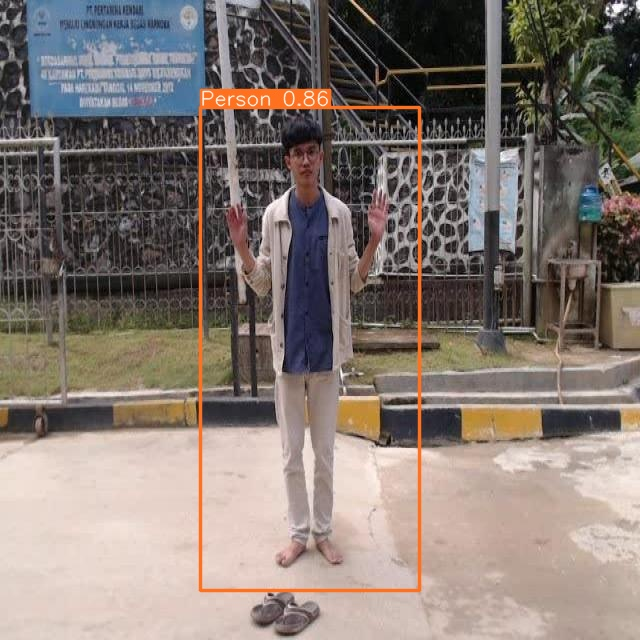

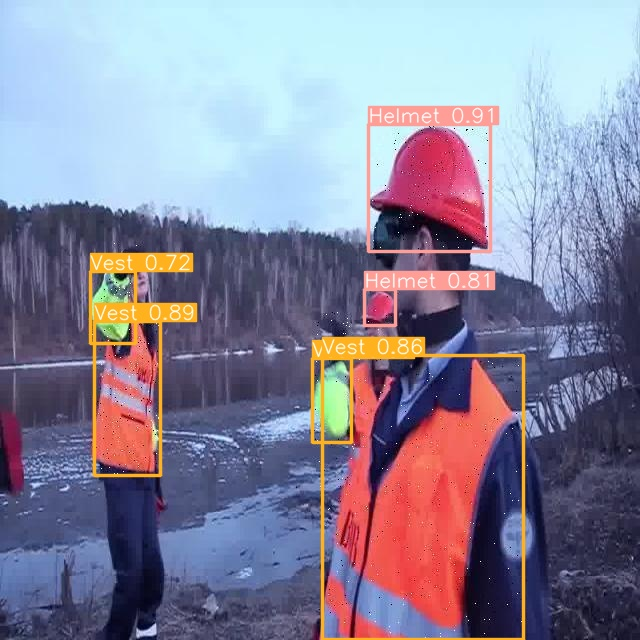

In [ ]:
import glob
from IPython.display import Image, display

for image_path in glob.glob(f'/content/datasets/PPE-1/runs/detect/predict/*.jpg')[:2]:
      display(Image(filename=image_path, width=600))
      print("\n")

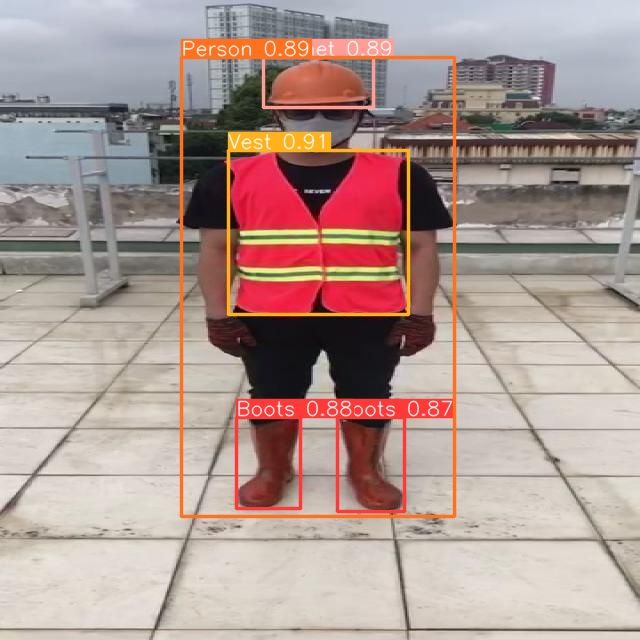

In [ ]:
import glob
from IPython.display import Image, display

for image_path in glob.glob(f'/content/datasets/PPE-1/runs/detect/predict/Video4_4_jpg.rf.d71b0a9946c24400f3c948e00903f291.jpg')[:2]:
      display(Image(filename=image_path, width=600))
      print("\n")

Save model

In [36]:
# Correct model weights path
model_weights = '/content/drive/MyDrive/Colab_Notebooks/Yolo/PPE.v2i.yolov8/runs/detect/train/weights/best.pt'
# Copy them to a folder in your Google Drive
!cp {model_weights} '/content/drive/MyDrive/Colab_Notebooks/Yolo/PPE_Models/'

In [38]:
# Path where inference results are saved
results_path = '/content/drive/MyDrive/Colab_Notebooks/Yolo/PPE.v2i.yolov8/runs/detect/predict2'

# Copy them to Google Drive
!cp -r {results_path} '/content/drive/MyDrive/Colab_Notebooks/Yolo/PPE_Models/'


## Deploy model on Roboflow and HuggingFace

Once you have finished training your YOLOv8 model, you’ll have a set of trained weights ready for use. These weights will be in the `/runs/detect/train/weights/best.pt` folder of your project. You can upload your model weights to Roboflow Deploy to use your trained weights on our infinitely scalable infrastructure.

The `.deploy()` function in the [Roboflow pip package](https://docs.roboflow.com/python) now supports uploading YOLOv8 weights.

To upload model weights, add the following code to the “Inference with Custom Model” section in the aforementioned notebook:

In [ ]:
project.version(dataset.version).deploy(model_type="yolov8", model_path=f"{RootDir}/runs/detect/train/")

In [ ]:
#While your deployment is processing, checkout the deployment docs to take your model to most destinations https://docs.roboflow.com/inference

In [ ]:
#Run inference on your model on a persistant, auto-scaling, cloud API

#load model
model = project.version(dataset.version).model

#choose random test set image
import os, random
test_set_loc = dataset.location + "/test/images/"
random_test_image = random.choice(os.listdir(test_set_loc))
print("running inference on " + random_test_image)

pred = model.predict(test_set_loc + random_test_image, confidence=40, overlap=30).json()
pred

# Deploy Your Model to the Edge

In addition to using the Roboflow hosted API for deployment, you can use [Roboflow Inference](https://inference.roboflow.com), an open source inference solution that has powered millions of API calls in production environments. Inference works with CPU and GPU, giving you immediate access to a range of devices, from the NVIDIA Jetson to TRT-compatible devices to ARM CPU devices.

With Roboflow Inference, you can self-host and deploy your model on-device. You can deploy applications using the [Inference Docker containers](https://inference.roboflow.com/quickstart/docker/) or the pip package.

For example, to install Inference on a device with an NVIDIA GPU, we can use:

```
docker pull roboflow/roboflow-inference-server-gpu
```

Then we can run inference via HTTP:

```python
import requests

workspace_id = ""
model_id = ""
image_url = ""
confidence = 0.75
api_key = ""

infer_payload = {
    "image": {
        "type": "url",
        "value": image_url,
    },
    "confidence": confidence,
    "iou_threshold": iou_thresh,
    "api_key": api_key,
}
res = requests.post(
    f"http://localhost:9001/{workspace_id}/{model_id}",
    json=infer_object_detection_payload,
)

predictions = res.json()
```

Above, set your Roboflow workspace ID, model ID, and API key.

- [Find your workspace and model ID](https://docs.roboflow.com/api-reference/workspace-and-project-ids?ref=blog.roboflow.com)
- [Find your API key](https://docs.roboflow.com/api-reference/authentication?ref=blog.roboflow.com#retrieve-an-api-key)

Also, set the URL of an image on which you want to run inference. This can be a local file.

_To use your YOLOv5 model commercially with Inference, you will need a Roboflow Enterprise license, through which you gain a pass-through license for using YOLOv5. An enterprise license also grants you access to features like advanced device management, multi-model containers, auto-batch inference, and more._

## 🏆 Congratulations

### Learning Resources

Roboflow has produced many resources that you may find interesting as you advance your knowledge of computer vision:

- [Roboflow Notebooks](https://github.com/roboflow/notebooks): A repository of over 20 notebooks that walk through how to train custom models with a range of model types, from YOLOv7 to SegFormer.
- [Roboflow YouTube](https://www.youtube.com/c/Roboflow): Our library of videos featuring deep dives into the latest in computer vision, detailed tutorials that accompany our notebooks, and more.
- [Roboflow Discuss](https://discuss.roboflow.com/): Have a question about how to do something on Roboflow? Ask your question on our discussion forum.
- [Roboflow Models](https://roboflow.com): Learn about state-of-the-art models and their performance. Find links and tutorials to guide your learning.

### Convert data formats

Roboflow provides free utilities to convert data between dozens of popular computer vision formats. Check out [Roboflow Formats](https://roboflow.com/formats) to find tutorials on how to convert data between formats in a few clicks.

### Connect computer vision to your project logic

[Roboflow Templates](https://roboflow.com/templates) is a public gallery of code snippets that you can use to connect computer vision to your project logic. Code snippets range from sending emails after inference to measuring object distance between detections.